# 1. Gender Classification Using Deep Neural Networks (DNN)

## 1.1 Necessary libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split

## 1.2 Download the dataset

In [22]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [23]:
y = df['classification'].astype("category").cat.codes.values # y labels into numbers
names = df['first_name'].apply(lambda x: x.lower()) # input names

## 1.3 Encoding Words

In [24]:
maxlen = 20
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
char_index = dict((c, i) for i, c in enumerate(vocab))

In [25]:
x = []
# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_encod_names(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


x = prepare_encod_names(names.values)

## 1.4 Split the data into test and train

In [26]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the DNN Model

In [44]:
model = keras.Sequential()                                  # Sequential model
n_inputs = 28                                               # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')  # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
l2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(l2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
model = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()                                             # print the model

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20, 28)]          0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 20, 64)            1856      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20, 128)           8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 2561      
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_______________________________________________________

## 1.6 Fitting the data into model

In [45]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
scores = model.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.5650 - accuracy: 0.7768 - val_loss: 0.3230 - val_accuracy: 0.8547
Epoch 2/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3414 - accuracy: 0.8476 - val_loss: 0.3210 - val_accuracy: 0.8612
Epoch 3/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3333 - accuracy: 0.8533 - val_loss: 0.3150 - val_accuracy: 0.8649
Epoch 4/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3273 - accuracy: 0.8553 - val_loss: 0.3257 - val_accuracy: 0.8564
Epoch 5/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3212 - accuracy: 0.8600 - val_loss: 0.3089 - val_accuracy: 0.8650
Epoch 6/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3230 - accuracy: 0.8587 - val_loss: 0.3090 - val_accuracy: 0.8641
Epoch 7/20
1890/1890 [==============================] - 9s 5ms/step - loss: 0.3222 - accuracy: 0.8578 - val_loss: 0.3060 - val_accuracy:

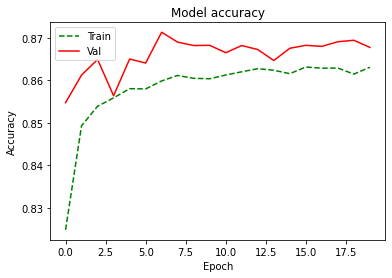

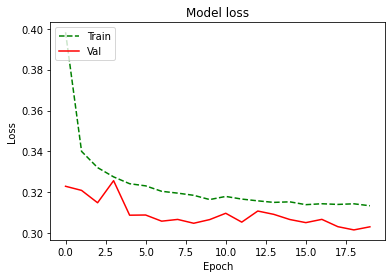

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], 'g--')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], 'g--')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

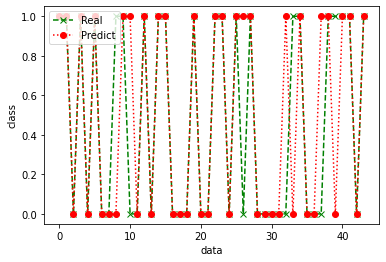

In [48]:
y_pred =(model.predict(x_test) > 0.5).astype("int32")
plt.figure(2)
plt.plot(y_test[6:50], 'g--x')
plt.plot(y_pred[6:50], 'r:o')
plt.ylabel('class')
plt.xlabel('data')
plt.legend(['Real', 'Predict'], loc='upper left')
plt.show()